In [199]:
import tensorflow as tf
import numpy as np
import cv2
import base64
import io
import json
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Flatten
from tensorflow.keras.layers import Dense, Reshape, Input, BatchNormalization
from tensorflow.data import Dataset
from PIL import Image

from plt_fn import show_images

IMAGE_SHAPE = (128,128)
batch_size = 128
tf.random.set_seed(10)

In [160]:
def preprocessing_fun(img):
#     print(img.shape, img.astype(int))
#     print(filename)
#     img = cv2.imread(filename)
#     gray = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR).astype(np.uint8)
    gray = img.astype(np.uint8)
#     img = cv2.fastNlMeansDenoising(gray,None,5,7,21)
#     img = cv2.fastNlMeansDenoising(gray, None, 3, 7, 21)
    ret,thresh = cv2.threshold(img,170,255,cv2.THRESH_BINARY)
    kernel = np.ones((5, 5), np.uint8)
    erode = cv2.erode(thresh, kernel, iterations = 1)
    img = cv2.bitwise_or(img, erode)
    
    kernel = np.ones((1, 1), np.uint8)
    img = cv2.erode(thresh, kernel, iterations = 1)
    
  
#     dec = 60
#     img = np.where(img < 250, img - dec, img)

    
    gray = 255*(img < 128).astype(np.uint8)
    coords = cv2.findNonZero(gray)
    x, y, w, h = cv2.boundingRect(coords)
    rect = img[y:y+h, x:x+w]
    
#     img = cv2.copyMakeBorder(rect,top,bottom,right,left,cv2.BORDER_CONSTANT,value=255)
    img = cv2.copyMakeBorder(rect,5,5,5,5,cv2.BORDER_CONSTANT,value=255)
    img = cv2.resize(img, (80,80), interpolation = cv2.INTER_NEAREST)
    
    img = np.where(img < 0, 0, img)
#     img = cv2.convertScaleAbs(img, alpha=0.5, beta=0)
#     gray = img.astype(np.uint8)
#     img = cv2.fastNlMeansDenoising(gray,None,5,7,21)
#     img = cv2.blur(img, (5, 5))
    img = img.reshape(80,80,1)
#     img = crop_white_space(img)
    
    return img

In [203]:
img_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#     rescale=1./255,
    rotation_range=20,
    preprocessing_function = preprocessing_fun,
    validation_split=0.25
)

In [204]:
training_gen = img_datagen.flow_from_directory(
    'TRAIN',
    target_size=(80,80),
    color_mode='grayscale',
    batch_size=128,
    shuffle=True,
    seed=10,
    subset="training"
)
validation_gen = img_datagen.flow_from_directory(
    'TRAIN',
    target_size=(80,80),
    color_mode='grayscale',
    batch_size=128,
    shuffle=True,
    seed=10,
    subset="validation"
)

Found 12028 images belonging to 33 classes.
Found 3997 images belonging to 33 classes.


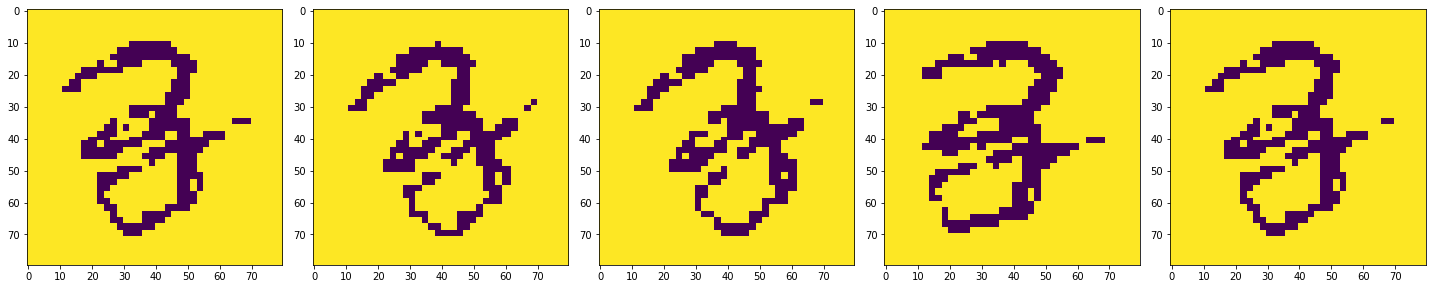

In [205]:
augmented_images = [training_gen[0][0][0] for i in range(5)]

fig, axes = plt.subplots(1, 5, figsize=(20,20))
axes = axes.flatten()
for img, ax in zip( augmented_images, axes):
        ax.imshow(img)
plt.tight_layout()
plt.show()

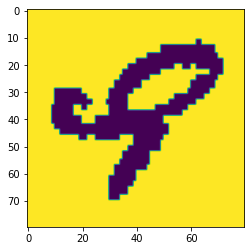

In [206]:
# print(training_gen[1][0][0])
plt.imshow(training_gen[1][0][0].astype("uint8"))

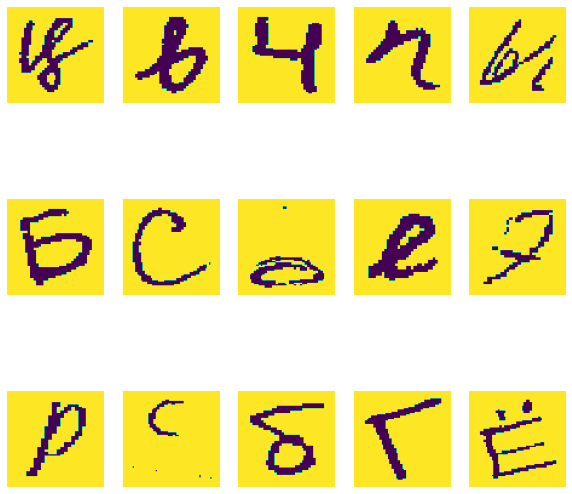

In [207]:
plt.figure(figsize=(10, 10))
def show_images(train_ds, class_names, n = 9):
    images, labels = train_ds[2]
    for i in range(15):
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[i].astype("uint8"))
#         plt.title(class_names[labels[i]])
        plt.axis("off")
show_images(training_gen, np.array(set(training_gen.labels)))

In [241]:
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(80,80, 1))
]

In [242]:
def conv_2d_pooling_layers(filters, drop_prob):
    return [
        tf.keras.layers.Conv2D(
            filters,
            (3,3),
            activation='relu',
            padding='same'
        ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(drop_prob),
    ]
core_layers = \
    conv_2d_pooling_layers(32, 0.25) + \
    conv_2d_pooling_layers(64, 0.25) + \
    conv_2d_pooling_layers(128, 0.5)

In [243]:
dense_layers = [
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(33)
]

In [244]:
model = tf.keras.Sequential(
    preprocessing_layers +
    core_layers +
    dense_layers
)
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 80, 80, 1)         0         
                                                                 
 conv2d_18 (Conv2D)          (None, 80, 80, 32)        320       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 40, 40, 32)       0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 40, 40, 32)        0         
                                                                 
 conv2d_19 (Conv2D)          (None, 40, 40, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 20, 20, 64)       0         
 g2D)                                                 

In [245]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer='adam',
    loss=loss,
    metrics=['accuracy']
)

In [249]:
history = model.fit(
    training_gen,
    steps_per_epoch=int(np.ceil(training_gen.n / float(batch_size))),
    validation_data = validation_gen,
    validation_steps=int(np.ceil(validation_gen.n / float(batch_size))),
    epochs = 10
)

Epoch 1/10
94/94 [==============================] - 40s 426ms/step - loss: 0.2472 - accuracy: 0.9221 - val_loss: 0.4361 - val_accuracy: 0.8714
Epoch 2/10
94/94 [==============================] - 40s 429ms/step - loss: 0.2374 - accuracy: 0.9237 - val_loss: 0.4126 - val_accuracy: 0.8854
Epoch 3/10
94/94 [==============================] - 40s 429ms/step - loss: 0.2271 - accuracy: 0.9284 - val_loss: 0.4168 - val_accuracy: 0.8787
Epoch 4/10
94/94 [==============================] - 40s 426ms/step - loss: 0.2088 - accuracy: 0.9312 - val_loss: 0.4533 - val_accuracy: 0.8759
Epoch 5/10
94/94 [==============================] - 40s 430ms/step - loss: 0.2176 - accuracy: 0.9287 - val_loss: 0.4037 - val_accuracy: 0.8819
Epoch 6/10
94/94 [==============================] - 43s 454ms/step - loss: 0.1954 - accuracy: 0.9362 - val_loss: 0.4432 - val_accuracy: 0.8749
Epoch 7/10
94/94 [==============================] - 44s 468ms/step - loss: 0.2008 - accuracy: 0.9339 - val_loss: 0.4025 - val_accuracy: 0.8869

In [232]:
model.evaluate(validation_gen)

32/32 [==============================] - 3s 97ms/step - loss: 0.5250 - accuracy: 0.8539


[0.5249629616737366, 0.8538904190063477]

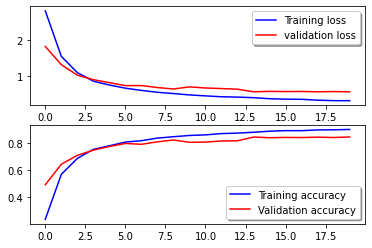

In [230]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

(80, 80, 1)
13 [[ -1.6181331 -15.313476   -6.1717167  -5.3157907 -12.558842   -5.0414543
    7.6525826 -14.78371     8.535083   -2.0274475   8.580066    4.3842397
    1.5450884  12.0463505 -12.449413    9.863495    4.9513087  -9.165189
    5.5630474  -5.028004   -8.214235    3.1751246  -4.19927    -1.9298857
    1.8493371  -4.1111617 -10.754676    6.962208   -6.2400203 -20.34776
    9.798727   -2.0409129  -5.4101257]]


'н'

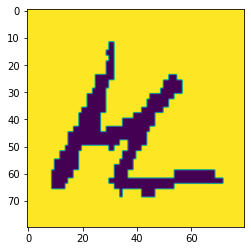

In [250]:
print(validation_gen[0][0][0].shape)
d = validation_gen[0][0][1]

plt.imshow(d.astype("uint8"))
prediction = model.predict(np.array([d]))
ind = np.argmax(prediction)
print(ind, prediction)
class_names = ['а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё']
class_names[ind]

In [251]:
model.save('weight/20-epoch')

INFO:tensorflow:Assets written to: weight/20-epoch/assets


(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
[[  3.6893692  -14.056506     1.737197    -6.308703     7.300615
   -5.1581635   -1.7271068   -8.468527    -7.732874    -5.44962
   -1.5303472    3.0427902   14.205931    -0.16403937  -2.4549835
   -5.789156     1.5427986  -13.49664     -1.7090415   -2.7200227
   -3.6238463   -4.37272     -0.2966708   -8.2300205    3.9720051
   -2.1563437   -5.628737   -12.4800825   -7.9611597  -10.737477
    3.416676     0.02968141  -8.691917  ]
 [  0.98533756 -13.005726    -1.61532     -8.790618     3.6802852
  -10.589163    -1.8276631  -16.416887     1.9933594    2.89026
   -5.011643    -3.6595445    2.1286976   -5.0203886   -9.753825
  -10.285355   -12.208077   -13.370899    -7.885035     3.2015836
   -0.36398935  -9.868611    14.1666975    5.088341    13.371074
   17.268517    -5.5539603    4.50357     -6.7853417   -8.742326
   -2.265321    -3.220541    -3.8943584 ]
 [ -2.425707     3.7660868    6.8644743    1.5860666    1.2961905
    2.0906677   -2.

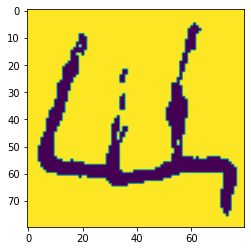

In [252]:
hash = "/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCACAAIADASIAAhEBAxEB/8QAHAABAAEFAQEAAAAAAAAAAAAAAAcBAgMEBgUI/8QAMhAAAgIBAwMCBQIEBwAAAAAAAAECAwQFBhEHITFBURITFCJhkaEjM4GxMjRScXLR4f/EABQBAQAAAAAAAAAAAAAAAAAAAAD/xAAUEQEAAAAAAAAAAAAAAAAAAAAA/9oADAMBAAIRAxEAPwCfwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAANLUdX07SKY26jm0YtcnxGV01FN/1A3QaOma1pms1St03Px8uEezlTYpJfobwAAAAAAAAAtg5SjzKPwvnxzyXAAAAABjvvqxcey++yNdVcXKc5PhRS8tgMjIqxced99ka6q18UpyfCSPnzqfl5m+twY9WmYWRfpeAv8zRBzUvifdpLz4Pc1rWr+qO4I6ZpeTPH2zifdl5TfwK3/z2MebuDI1iVG1enWPOiqtOu7MUGkors+7A57p7dXonUWjF0LJybaMmSrvptq+B8Jd5S9uH/c+kDh9hdO8baEbMq+76vU7l/Eva8e6X/Z2FmdjV51WFO6KyLYSnCvnu4x45f7oDYAAAAAAAAKNtSSUeU/L58FSLepXUDMwciO29tKVmr3NRndXw/k8+n/L+wEpAiXZW+K9vaHZVvTXpfXwnJOORYp2Lv44jy2VyOtD1HM+k2tt/M1KbfCsmnFP8pLl8foBK9lkKq5TsnGEIrlyk+EkQP1b6hLWJrbWgXu6lySyLaHz8yX+hcHR27F3ZvPJd27NV+iw3HiOFgzfHHHrz6nH19Pdz7A3HPUNH0urVcar+XO3vyn+E+U0Bs7P6S6/n48Ia5l24GlNqz6SufErOffjx/UnHS9JwNGwoYmn41dFMUlxBcc/l+7Izp1/q1qEavl7f07FhYv5kn/h/PDke/g4HUWyuEM/U9KgueJuuuTk17r8gdjnZ1GnYV2VkTUKqoOcm36IiLp1qGbu3qVqW5Mico40aJ0Y1bT4UW14/T9z0uo1ORpO17K8jUVfk59iorTh6Pzx3/wBjqti7TxNsbfxqavjlfKClZKUvV+eF6AdUAAAAAAADzNww1WzQcuGiyrjqEoNUysfZMhunpbvLPz6687PrxqpQ/j5NU/vnz5T47t/oTuAI70Xo3tvS8lX3weY4tSULI8Q548td+Tu8PT8PTqVThYtOPWvEaoKK/Y2QAAAGHGtttg5XUOlqTSi5KXK9+xlfPD4459OSoAjXXtLu3B1W0ui5Tli6fT89uD+2M/ZklLsi1VwjNzUYqT8vjuy4AAAAAAAAAAAALWm2uOOPXkRgoc92+Xz3fIFwKJJLheCoAAAYvvtlKLUq1GS4aa+5GUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA//Z"
hash2 = "/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCACAAIADASIAAhEBAxEB/8QAHAABAAEFAQEAAAAAAAAAAAAAAAcCBAUGCAED/8QAMhAAAQQBAwMCBAUDBQAAAAAAAQACAwQFBhESByExQWETFFFxFSIjMkIWJJEXYnKBgv/EABQBAQAAAAAAAAAAAAAAAAAAAAD/xAAUEQEAAAAAAAAAAAAAAAAAAAAA/9oADAMBAAIRAxEAPwCf0REBERAREQEREBERAREQEREBERAREQEREBFic3nq+EjjdM0u5uA2B8D6rJwysnhZLGd2PAcD7IK0REBERAVBkYH8C9vI+m/dVEgAk+B5UU3bWQz2uz+F2XMijPFp37HbygldFTGHCNoed3BoBPuqkBERAREQFTI9scbnuOzWgkn2CqUedWNXO09gPlKx/urYLAd/2tPlBYyzWtWZC1LS4SwidrC1x32Y0+QpPYxsbGsYAGtGwA9Aoj6HYm5Vxtm7LG4V5XlsbnO3JUvICIsLjs1JfytisIQIYnFofv5IQZpERBY5m2yliLViR3FrIz3Wl6Ew5E4yYaWsfyOx9yszrmdrsVHj2vAntyBjR9R6rMYmk+jX+C7bi1rQ3b2HdBkUREBERAREQUO58m8SA3f826gHqLX/AKl6tQYcTOLXxNjDd/ytIPc/fZTVqfP19M4C1lrQcYq7QSGjuSTsFBGgYJdS9WHZVrnlrZnzyNd/FpHYIOgMPi4MNia2Prj9KBgYD9fdXyIgLVcZJHHnZmVDyDpXfE+/qtivWY6lKaeSRsbWtP5nH19FrOk8dZikNuZ7f1HOf2/kHeEG3IfCKxzN/wDDMLdvcS75eB8uw9dhugh7Uublr9bsfVlnMkFWPfhv2Bd3U01LDbVZkzfDvC4tu5e/l8tYy7pnG3I4va71a3fsF2DpcvdpfGOkBDzXYXb/AF2QZdERAREQERCghvrfm7Ajq4CtI13zTecsXrsD2O/3Wx9KNJjT+m22rEe125+o4nuWt9Buow6jXfnuoc8cp4lthlXf/YCD2XRNKGOvSghjGzGMDWj22QfdEQnsg1DqI58mAhpRH89qzGz/AM791c6dsm5dmZH2rUR8BhHhx9f8LTuo+adBq+jDHMA2nXkmfGfBc4flW86Pq/L6ZpvLA2Sdgnk/5O7lBnl8rVeO3Wlryt5RysLHD6ghfVEHH0uGip9QDiYCZIhf4bgduJPhdeVY2w1YYmgBrGNaAPYKJsjTw+M10f7SJs004fy9Wn1/ypbje1zG8XAjYeCgrReFwHkgfdAQfCD1ERAQoiDnjqxo/Kw6ns5aKCSapO4Sh8Tdy130VjiOqercLEK08T7LIxts9h5N+5XShAcNiNx7rHyYHFSvke/H13Ok/cSzyghCr1o1HBHHLZx7Z2ucQGg8SdlnsV1sktvAt4lsMbhvy+KOykWTR2npZGvdia3Ju+x4/XyrD/TfSvEg4uM99+/oggvWmsqWoNVy2Y4zEyVsUbnE79mlTrjNX4GHF1Im3oyGwA9j4AC07VPRKlkrLrOIlbXLtt43/tA9ljIOh9xsJi+fZEzb+JPdBJDtf6eEQeLzHdt9gVqd/qxFAXVqUfzE3MkOHgNXmP6LY+CJosWHF4G27Ce6z2M6YYLG7ECSUgEbv90EOZSxlMzquxaql8ks7RtsNwwq7hyuu8VXc0PmdGHjZ5aTtt6KfaOCxuOaBWpxMIG3LbuVeGvCWcDEwt+myDnduf1pkjLJYsSxiJvZrWHuVfU9Yamw2Ug/EZyK+wc4PG24U7NoVGuLm1ogT68VAnWaU3dZUalc7j4fwyG/dBPOMvx5PGwXIv2St5BXax+DqilhKVcDbhC0bf8ASyCAiIgIiICIiAiIgIiICIiAoB1LiJ4er+P5sc/4tgOaD3Gyn5Y6zhKNvKQZGaEOswjZjvogv2DiwD6BVIiAiIgIiICIiAiIgIiICIiAiIgIiIP/2Q=="
hash3 = "/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCACAAIADASIAAhEBAxEB/8QAGwABAAIDAQEAAAAAAAAAAAAAAAUGAQQHAgP/xAA0EAABBAECBQIDBwMFAAAAAAABAAIDBAUGEQcSITFBE1EiYYEUFSMyQnGRJDM0NlJiwdH/xAAUAQEAAAAAAAAAAAAAAAAAAAAA/8QAFBEBAAAAAAAAAAAAAAAAAAAAAP/aAAwDAQACEQMRAD8A7+iIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIvmZ4mzthMjRK4EtZv1IHc7IPoiIgIiICIiAiIgIiICIiAvEs0cETpZntjjaN3OcdgAsTzR14XzTPayNg3c5x2AC5VkLVzinmjjsZZkr6dqn+qkA29c79h8u6CRyev7mduy4fRlZ1qYAtkukbMjPuN+hU1pPRsmHsvyuWvzZDLzM5XTSO6Mae7WjsFOYXA47T9FtTH12xRgdTt8Tv3KNzuPkzIxUU7ZLfI57ms68gG3f27oJJERAREQEREBERAREQF4llZDE6WRwYxg3c4nYAL2uR8RdWWcnlxpDGTNihlAFy2H7emD3B6bdt0DL5K1xN1DHhMTIWYOs/e5YAP4m3gEK+mTA6Iw7IuaGpAwfC39Tz/2VUsVmYMLU+4dGYp158LWiSw47Nc4+SVLY7Rt7ITtu6oui3KHczazAPTZ8t/I+SDQlyOptZAx42F+Oxr92mbmHO4e+/j9grNpzSON02wurtdJZePxJ5HEucfPdTscbIo2xxtaxjRs1rRsAF6QEREBERAREQERYJAG5OwCDKwSGglxAA7kqn5riDUo2ZKWLpWcrda7k5a7CWB3kFw37fJaDsbqTPVpLueyAxmP9Nzvs9Ulsgbt+rfcD+D9EGNdcS6Wn6ElbHh1rIygsiDR8IJ6b7+foq1oThbNbo/e2orU3qXAXurtBY4bncEnuD8lrcLcXDqHWWRz765NOqeSqHvLvi7c3UDx17Lt6DSxmIoYeqK1CsyCPyGjq4+5PkrdUBlNQXKmXZj6OJkvO9P1JCyZjCwb+xO5XuDVWPffbQtF9O0/+3HONuf32PnugnEREBERAREQEREFayGuMNUuihXtQ2rvNyuiZK0BnuXOPQbfyq/6dnWNqwJc42SiG8rqeMk5vPUOcDsD9d1Z7ui9P5GJ0VvGwzQuf6hjd+Xm99vdSmPxtHFVW1cfUgqwN7RwsDR/AQaeH0/jsLX9PHUoqgJHNyDcuA9yfdVji7mXYrQ88MDy2zce2uwN/MQT12H7K+rkPFN7rHEHR9GUMNUTCVzXu2Djz7EdvZBd9AYAad0jTquLjPI31pi7vzu6kfTsrOiIKs3TDW8R3ajdzOL6Igb16NIP/hUfxN027L4JuQqzfZ7uOJmZIB1LdurVeHODWlziAB1JPhU3PZaxqGGTC6elhd9oY5s1tx3a1vYhg8n59gg2+HmYnzmicfdtOLpy0seT3JB2VoUZp7DQ6fwFPFwABleMN6eT5P8AKk0BERAREQEREBERAVH4k6Ik1bjYbFCQRZWgTJWd0Aef9hPj5H3V4RByStxXzWHAqal0nkGzRtHPPXYeXt1JB8/sVLP4j5TKvEWm9L5CxvtvNaYYmt3+R7rohaHDYgEexWdkHP36a1Tqr/UWTGPok/4NE9XD/k5W7EYHG4KH0sfVbCC0NLh1JA7bn6lSSICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiD/9k="

def f(h):
    img = base64.b64decode(h)
    img = Image.open(io.BytesIO(img))
    img = np.array(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.uint8)
    
    img = preprocessing_fun(img)
    img = img.astype(float)
    print(img.shape)
    return img


plt.imshow(f(hash2).astype("uint8"))
imgs = np.array([f(hash),f(hash2),f(hash3)])

model2 = tf.keras.models.load_model('weight/20-epoch')
prediction = model2.predict(imgs)
print(prediction)
indx = np.argmax(prediction, axis=1)
print(indx)
print([class_names[ind] for ind in indx])



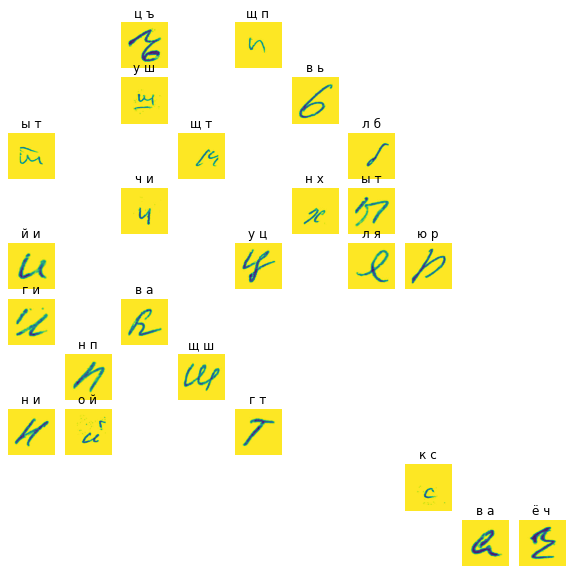

In [253]:
labels = ['а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё']

y_right = [
    'ц', 'н', 'ъ', 'о', 'п', 'ь', 'ж', 'ц', 'м', 'в',
    'э', 'к', 'ш', 'ж', 'ю', 'ь', 'й', 'д', 'е', 'х',
    'т', 'з', 'д', 'т', 'у', 'х', 'б', 'ж', 'ь', 'ь',
    'а', 'ъ', 'и', 'ь', 'к', 'х', 'т', 'р', 'б', 'ш',
    'и', 'д', 'ж', 'м', 'ц', 'ё', 'я', 'р', 'е', 'й',
    
    'и', 'е', 'а', 'с', 'л', 'э', 'ц', 'ъ', 'л', 'с',
    'ю', 'п', 'ж', 'ш', 'р', 'х', 'ш', 'и', 'л', 'ч',
    'и', 'й', 'м', 'а', 'т', 'в', 'б', 'д', 'х', 'т',
    'т', 'л', 'щ', 'ё', 'ц', 'м', 'р', 'с', 'я', 'г',
    'ю', 'ц', 'у', 'и', 'х', 'ё', 'е', 'я', 'а', 'ч',
]
with open('json/1.json') as json_file:
    data = json.load(json_file)
    data = data["response"]["data"]
    
    predicted_labels = []
    imgs = [] 
    for hash in data:
            img = base64.b64decode(data[hash])
            img = Image.open(io.BytesIO(img))
            img = np.array(img)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.uint8)
            imgs.append(img)
            img = preprocessing_fun(img)
            prediction = model.predict(np.array([img]))
            ind = np.argmax(prediction)
            predicted_label = labels[ind]
            predicted_labels.append(predicted_label)
    
    
    plt.figure(figsize=(10, 10))

    for i in range(100):
        ax = plt.subplot(10, 10, i + 1)
        if (not y_right[i] == predicted_labels[i]):
            plt.imshow(imgs[i].astype("uint8"))
            plt.title(predicted_labels[i] + ' ' + y_right[i])
        plt.axis("off")
             